In [3]:

import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


df = pd.read_csv("DATA.csv", encoding="latin-1")  

df.head()


,type,body
0,SPAM,alertamos sobre estafa con pagos en codigo cif...
1,SPAM,cod de acceso de microsoft <NUMBER>
2,SPAM,tu bono de <NUMBER> mb ha expirado o consumist...
3,SPAM,sin saldo llama al <NUMBER> y sigue comunicand...
4,SPAM,adelantamos la navidad en claro usa s <NUMBER>...


In [4]:

df = df.dropna(subset=['body'])
df['body'] = df['body'].astype(str)

# Función de limpieza
def clean_text(text):
    text = text.lower()                     # minúsculas
    text = re.sub(r'\d+', ' ', text)       # eliminar números
    text = re.sub(r'\W+', ' ', text)       # eliminar símbolos
    text = re.sub(r'\s+', ' ', text)       # eliminar espacios extra
    return text.strip()

# Aplicar limpieza
df['body'] = df['body'].apply(clean_text)

# Mapear etiquetas: HAM=0, SPAM=1
df['label'] = df['type'].map({"HAM": 0, "SPAM": 1})

df.head()


,type,body,label
0,SPAM,alertamos sobre estafa con pagos en codigo cif...,1
1,SPAM,cod de acceso de microsoft number,1
2,SPAM,tu bono de number mb ha expirado o consumiste ...,1
3,SPAM,sin saldo llama al number y sigue comunicandot...,1
4,SPAM,adelantamos la navidad en claro usa s number d...,1


C:\Users\ALEX\AppData\Local\Temp\ipykernel_17728\1811444455.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="type", palette="Set2")


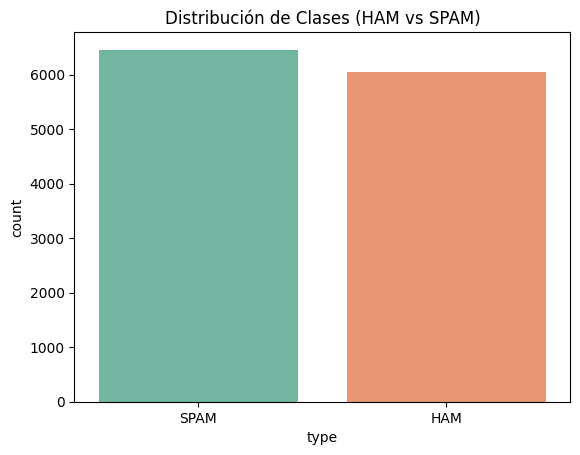

In [5]:
sns.countplot(data=df, x="type", palette="Set2")
plt.title("Distribución de Clases (HAM vs SPAM)")
plt.show()

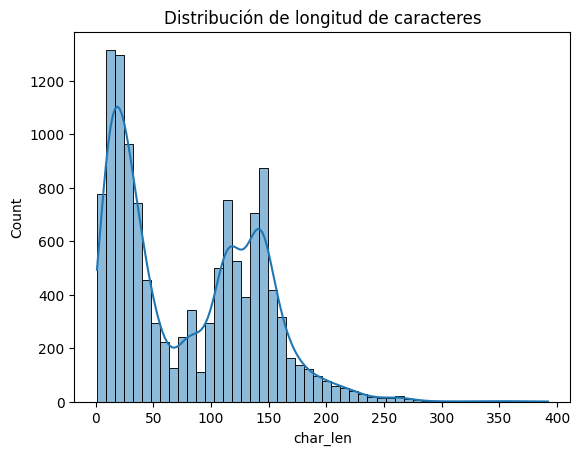

In [7]:
# Longitud de los mensajes
df['char_len'] = df['body'].astype(str).apply(len)
df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))

sns.histplot(df['char_len'], bins=50, kde=True)
plt.title("Distribución de longitud de caracteres")
plt.show()



In [8]:
X = df["body"]
y = df["label"]

# Dividir train/test
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1,2)
)

X_train_vec = vectorizer.fit_transform(X_train_texts)
X_test_vec = vectorizer.transform(X_test_texts)

print("Shape train:", X_train_vec.shape)
print("Shape test:", X_test_vec.shape)


Shape train: (10012, 5000)
Shape test: (2504, 5000)


In [9]:
class SMSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)  # Convertir a tensor float
        self.y = torch.tensor(y.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear datasets
train_dataset = SMSDataset(X_train_vec, y_train)
test_dataset = SMSDataset(X_test_vec, y_test)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [10]:
class SpamClassifierNN(nn.Module):
    def __init__(self, input_dim):
        super(SpamClassifierNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 clases: HAM y SPAM
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

input_dim = X_train_vec.shape[1]
model = SpamClassifierNN(input_dim)


In [11]:
criterion = nn.CrossEntropyLoss()  # para clasificación multi-clase
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.0079
Epoch 2/10, Loss: 0.0078
Epoch 3/10, Loss: 0.0076
Epoch 4/10, Loss: 0.0076
Epoch 5/10, Loss: 0.0073
Epoch 6/10, Loss: 0.0073
Epoch 7/10, Loss: 0.0072
Epoch 8/10, Loss: 0.0072
Epoch 9/10, Loss: 0.0071
Epoch 10/10, Loss: 0.0072


In [19]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(y_batch.tolist())

# Métricas
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nReporte de clasificación:\n")
print(classification_report(all_labels, all_preds, target_names=['HAM','SPAM']))
print("Matriz de confusión:\n", confusion_matrix(all_labels, all_preds))


Accuracy: 0.9888178913738019

Reporte de clasificación:

              precision    recall  f1-score   support

         HAM       0.98      0.99      0.99      1212
        SPAM       0.99      0.99      0.99      1292

    accuracy                           0.99      2504
   macro avg       0.99      0.99      0.99      2504
weighted avg       0.99      0.99      0.99      2504

Matriz de confusión:
 [[1203    9]
 [  19 1273]]


In [20]:
mensajes_nuevos = [
    "Gana dinero fácil desde casa, haz clic aquí",
    "Hola, nos vemos mañana en la reunión",
    "Felicidades! Has ganado un bono de 500 soles",
    "Recuerda enviar el reporte antes del lunes"
]

labels_reales = [1, 0, 1, 0]  # SPAM=1, HAM=0


In [21]:
# Vectorizar
X_new_vec = vectorizer.transform(mensajes_nuevos)
X_new_tensor = torch.tensor(X_new_vec.toarray(), dtype=torch.float32)

model.eval()
with torch.no_grad():
    outputs = model(X_new_tensor)
    preds = torch.argmax(outputs, dim=1).tolist()

print("Predicciones:", ["SPAM" if p==1 else "HAM" for p in preds])


Predicciones: ['SPAM', 'HAM', 'SPAM', 'HAM']


In [22]:
from sklearn.metrics import f1_score, accuracy_score

f1_new = f1_score(labels_reales, preds)
acc_new = accuracy_score(labels_reales, preds)

print("F1-score en mensajes nuevos:", f1_new)
print("Accuracy en mensajes nuevos:", acc_new)


F1-score en mensajes nuevos: 1.0
Accuracy en mensajes nuevos: 1.0


In [23]:
import torch
import joblib

# Guardar modelo PyTorch
torch.save(model.state_dict(), 'spam_classifier_pytorch.pt')

# Guardar vectorizador TF-IDF
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Modelo y vectorizador guardados correctamente.")


Modelo y vectorizador guardados correctamente.
